# 로지스틱 회귀로 와인 분류하기

- 로지스틱 회귀로 와인 분류하기
- 6497개의 와인 샘플 데이터

In [2]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [3]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


- 처음 3개의 열 : 알코올 도수, 당도, pH 값
- class는 target 값으로 0이면 레드 와인, 1이면 화이트 와인임
- 누락된 데이터가 있는지 확인

In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


- 결측치 없는 것을 확인

In [5]:
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


- 알코올 도수와 당도, pH 값의 스케일이 다름
  - StandardScaler 클래스를 사용해 특성을 표준화해야함

In [6]:
data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

In [7]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42
)

- 샘플 개수가 충분히 많으므로 20% 정도만 테스트 세트로 나누었음

In [8]:
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [10]:
train_scaled

array([[ 0.01376574,  0.4646116 , -0.16888369],
       [ 1.60871671, -0.70299854,  0.26967864],
       [ 1.10504798, -0.70299854,  1.20945505],
       ...,
       [-0.82568214,  0.0267578 ,  0.14437512],
       [-0.82568214,  0.52716215, -0.23153545],
       [-0.82568214, -0.57789745,  1.83597265]])

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


- 생각보다 점수가 높지 않음
- 과소적합일 가능성이 있음
  - C의 값을 바꿔 볼 수 있음

In [12]:
print(lr.coef_, lr.intercept_)

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


- 위의 수가 정확히 어떤 의미를 가지는지 설명하기 어려움
  - 신뢰하지 않는 결과로 이어질 수 있음

# 결정트리

- **결정 트리**
  - 이유를 설명하기 쉬음
  - 질문을 하나씩 던져서 정답을 맞춰감
  - 사이킷런의 DecisionTreeClassifier 클래스를 사용

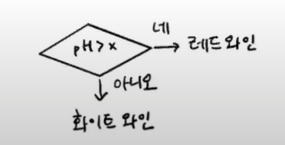

In [13]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target)) # 훈련 세트
print(dt.score(test_scaled, test_target)) # 테스트 세트

0.996921300750433
0.8592307692307692


- 과대적합일 가능성이 있음

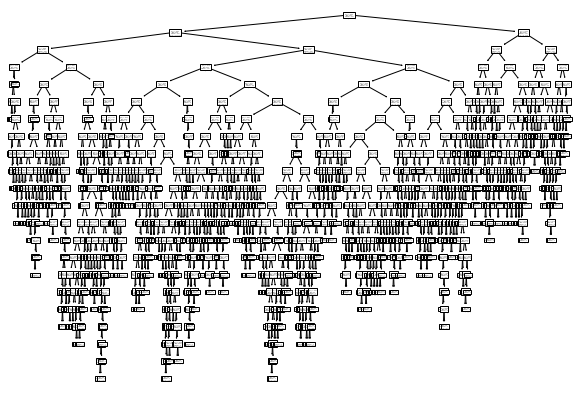

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

- 맨 위의 노드를 루트 노드
- 맨 아래 끝에 달린 노드를 리프 노드라고 부름

- 트리의 깊이를 제한할 수 있음
- max_depth : 1로 주면 루트 노드를 제외하고 하나의 노드를 더 확장하여 그림
- features_names : 특성의 이름을 전달할 수 있음

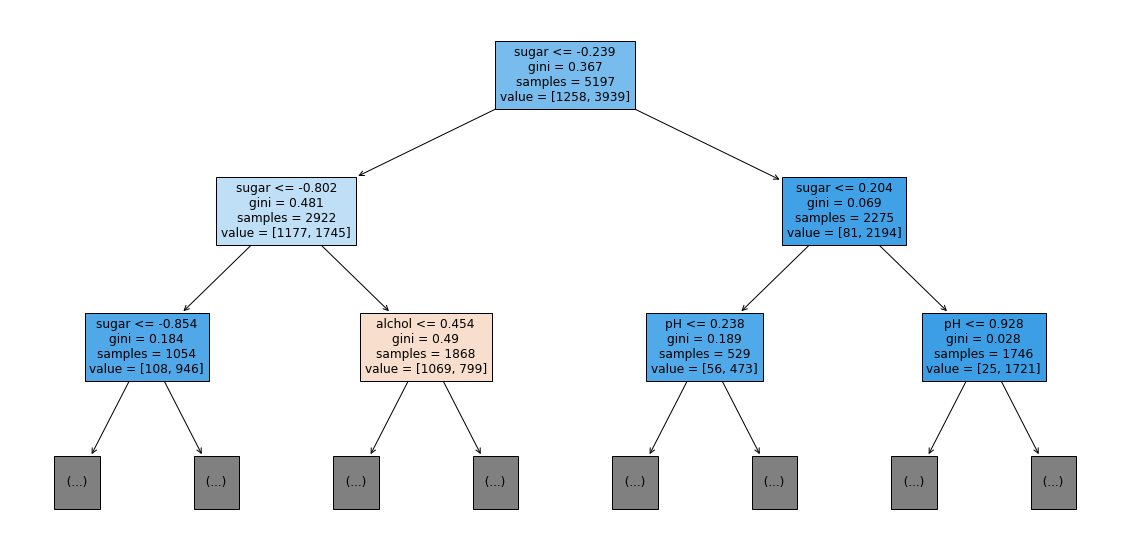

In [21]:
plt.figure(figsize=(20,10))
plot_tree(dt, max_depth=2, filled=True, feature_names=['alchol','sugar','pH'])
plt.show() #True로 색깔을 칠할 수 있음

- 테스트 조건 질문
- 당도가 -0.239와 같거나 작으면 왼쪽 가지로 감
- 그렇지 않으면 오른쪽 가지로 감
- 왼쪽이 Yes, 오른쪽이 No

- 루트 노드의 총 샘플 수(samples)는 5,197개임
- 음성 클래스(레드 와인) : 1,258개
- 양성 클래스(화이트 와인) : 3,939개


- 오른쪽 자식 노드가 진한 색으로 표시됨
- 어떠한 클래스의 비율이 높아지면 점점 진한 색으로 표시됨

- **불순도**
- gini는 지니 불순도를 의미함

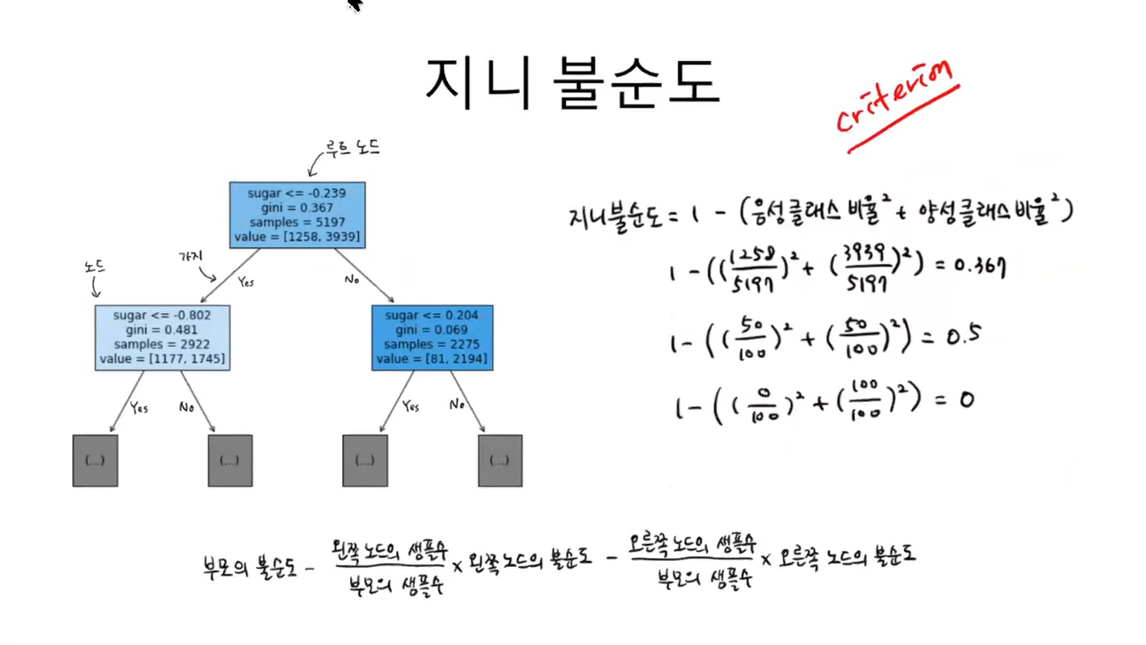

- 부모와 자식 노드 사이의 불순도 차이를 **정보 이득**이라 부름
- DecisionTreeClassifier 클래스에서 criterion='entropy'를 지정하여 엔트로피 불순도를 사용할 수 있음
  - 엔트로피 불순도는 밑이 2인 로그를 사용함
---
-음성 클래스 비율 x log2(음성 클래스 비율) - 양성 클래스 비율 x log2(양성 클래스 비율)

- 노드를 순수하게 나눌수록 정보 이득이 커짐
- 정보 이득이 최대가 되도록 노드를 분할함

- **가지치기**
- 트리의 최대 깊이를 지정함

In [22]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


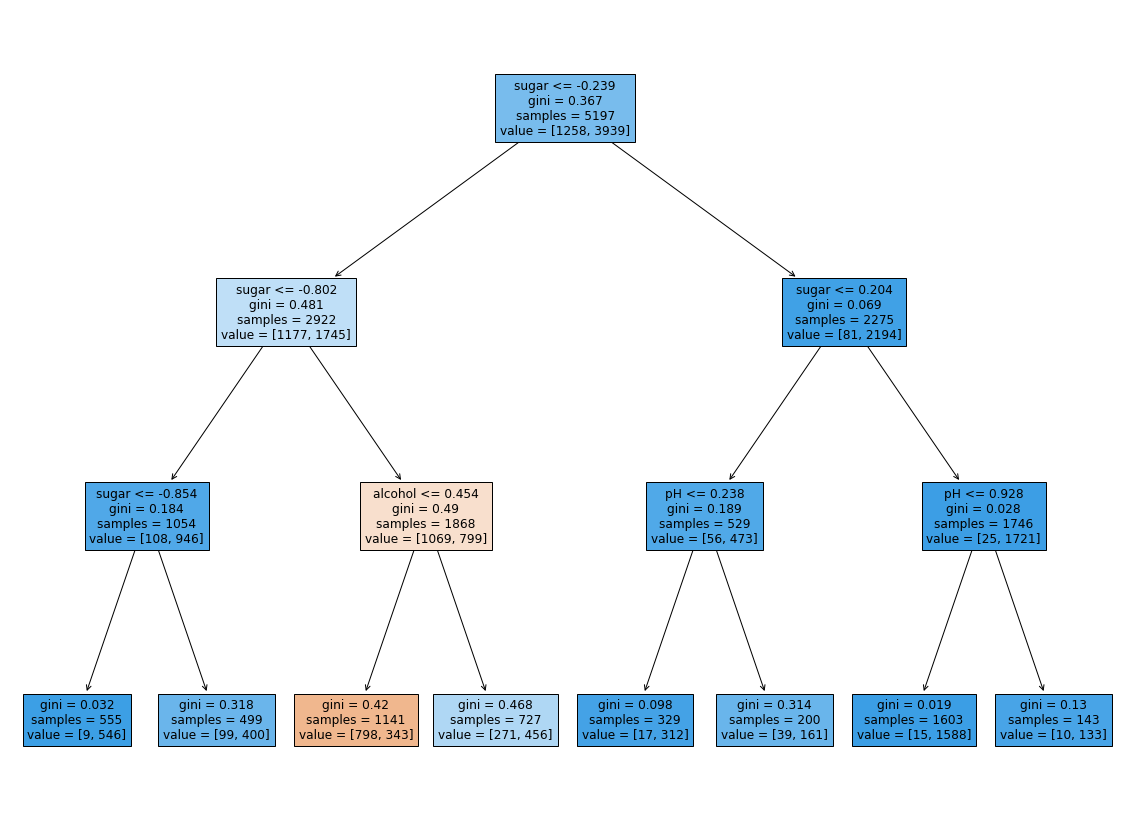

In [23]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

- 결정트리는 표준화 전처리 과정이 필요없음

In [25]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


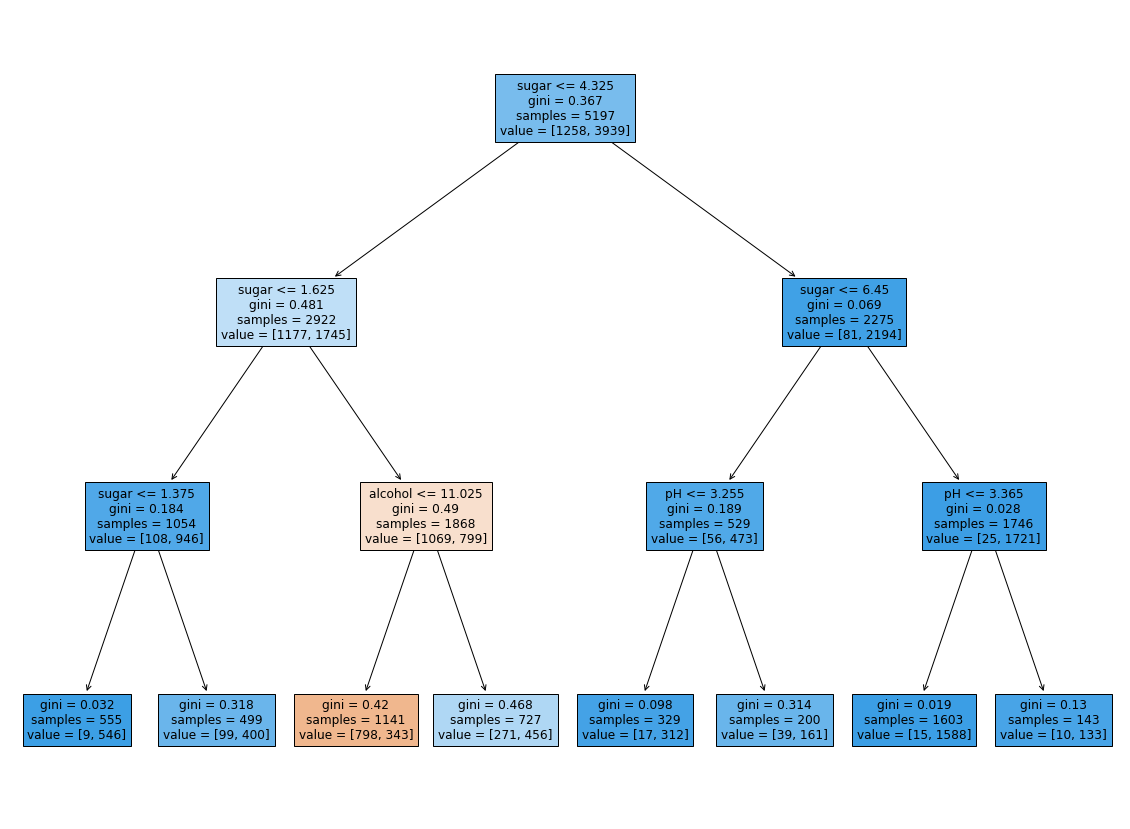

In [26]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

- 특성 중요도를 계산해줌

In [28]:
print(dt.feature_importances_)

[0.12345626 0.86862934 0.0079144 ]


- 두 번째 특성인 당도가 0.87 정도로 특성 중요도가 높음
- 모두 더하면 1이 됨
- 각 노드의 정보 이득과 전체 샘플에 대한 비율을 곱한 후 특성별로 더하여 계산함